In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from autocorrect import Speller
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from torch.utils.data import TensorDataset
from tqdm import tqdm
import pickle
tqdm.pandas()

RANDOM_STATE = 1

CRISP-DM lifecycle:
1. Business Understanding:
• Understand the project's objectives and business goals, and define the problem you aim
to solve with data mining.
2. Data Understanding:
• Gather and explore data to gain insights into its quality, structure, and relevance to the
problem. This step often involves data collection, data profiling, and initial data analysis.
3. Data Preparation:
• Preprocess and clean the data to make it suitable for modeling. Tasks include handling
missing values, dealing with outliers, and transforming variables.
4. Modelling:
• Select and apply appropriate data mining and machine learning techniques to build and evaluate
models. This step includes selecting algorithms, and training models, and assessing their
performance.
5. Evaluation:
• Assess the quality and effectiveness of the models developed in the previous step. This involves
metrics, cross-validation, and comparing model performance against the project's goals.
6. Deployment:
• Deploy the selected model(s) into the production environment for real-world use. This step may
involve integrating the model into business processes and monitoring its performance over time.


# Data Mining: CA2
by Peter and Jonas Wortmann
## 1. Data understanding and Preparation
Sentiment Analysis (SA) is a sub field of text mining and is used to extract the opinions, sentiments and subjectivity of text [[1]](#1). This assignment aims to classify the sentiment of user reviews based on their text features.

<a id="1">[1]</a> 
Walaa Medhat, Ahmed Hassan, Hoda Korashy,
Sentiment analysis algorithms and applications: A survey,
Ain Shams Engineering Journal,
Volume 5, Issue 4,
2014,
Pages 1093-1113,
ISSN 2090-4479,
https://doi.org/10.1016/j.asej.2014.04.011.
(https://www.sciencedirect.com/science/article/pii/S2090447914000550)

In [2]:
user_reviews = pd.read_csv("data/amazon.csv")
with open("StopWords.txt", "r") as f:
    stopwords = f.read().splitlines() 
user_reviews.head()

,reviewText,Positive
0,This is a one of the best apps acording to a b...,1
1,This is a pretty good version of the game for ...,1
2,this is a really cool game. there are a bunch ...,1
3,"This is a silly game and can be frustrating, b...",1
4,This is a terrific game on any pad. Hrs of fun...,1


In [3]:
user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  20000 non-null  object
 1   Positive    20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


<Axes: xlabel='Positive'>

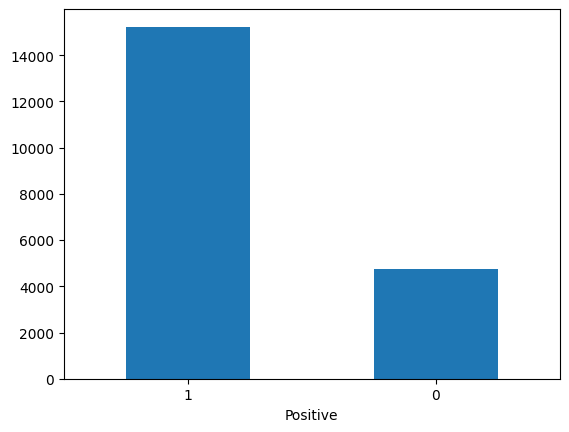

In [4]:
user_reviews.Positive.value_counts().plot(kind="bar", rot=0)

The dataset contains 20,000 rows. Each row consists of a user review and it's corresponding sentiments. The labels are encoded as integers, 1 = positive and 0 = negative. The dataset has unbalanced classes as you can see in the plot above.

### Data quality

In [5]:
user_reviews.iloc[0].reviewText

'This is a one of the best apps acording to a bunch of people and I agree it has bombs eggs pigs TNT king pigs and realustic stuff'

In [6]:
user_reviews.iloc[11].reviewText

'this. is fun an time consuming. works great on my kindle fire I really like this game so does my btother'

The reviews contain spelling mistakes, for example "btother", "realustic" and "acording" as you can see in the texts above. \
To avoid spelling mistakes the python library autocorrect is applied.

In [7]:
spell = Speller(lang='en')
spell(user_reviews.iloc[0].reviewText)

'This is a one of the best apps according to a bunch of people and I agree it has bombs eggs pigs NT king pigs and realistic stuff'

In [8]:
spell(user_reviews.iloc[11].reviewText)

'this. is fun an time consuming. works great on my kindly fire I really like this game so does my brother'

Even if the autocorrect library properly corrected all the mentioned mistakes, it wrongly corrected "TNT" to "NT" and "kindle fire" to "kindly fire" so this autocorrection is not used in this assignment.

In [9]:
from textblob import TextBlob
TextBlob(user_reviews.iloc[0].reviewText).correct()

TextBlob("His is a one of the best apes according to a bunch of people and I agree it has bombs eggs pigs TNT king pigs and realistic stuff")

In [10]:
TextBlob(user_reviews.iloc[11].reviewText).correct()

TextBlob("this. is fun an time consuming. works great on my kindle fire I really like this game so does my brother")

TextBlob also makes mistakes by falsely correcting "apps" to "apes". Since auto-spelling correction is a challenging task and leads to misleading results as seen above, no spelling correction is applied for the review texts.

The reviews also contain letters that are repeated multiple times, like "soooooo". Tokens like "sooooo" likely occur just once in the corpus and the meaning of the token can hardly be extracted. Further, missing whitespaces, e. g. "[...] make what this is all about.It's not relevant [...]", between the punctuation and the new sentence makes the sentence recognition challenging.

### Cleaning
[[2]](#2) compare punctuation removal in sentiment analysis scenarios of english and turkish reviews and come to the conclusion to keep punctuation and stopwords because they contain meaningful information in terms of their sentiment. [[3]](#3) also identifies punctuation as a good feature for Twitter sentiment analysis. Therefore, the stopwords and the punctuation are kept in the corpus, only lowercasing is applied in the cleaning process.

### Tokenization & Embeddings
In [[4]](#4), Transformer models outperform other machine learning models (i.e. LSTM, BoT, CNN) in sentiment analysis. Transformer is one of the most robust state-of-the-art approach in NLP. In this section we use the Transformer model BERT to tokenize the reviews to obtain BERT's 768-dimensional embeddings as input for our model.

<a id="2">[2]</a> Parlar, Tuba & Özel, Selma & Song, Fei. (2019). Analysis of data pre-processing methods for the sentiment analysis of reviews. Computer Science. 20. 123. 10.7494/csci.2019.20.1.3097. \
<a id="3">[3]</a>  Koto, F., Adriani, M. (2015). A Comparative Study on Twitter Sentiment Analysis: Which Features are Good?. In: Biemann, C., Handschuh, S., Freitas, A., Meziane, F., Métais, E. (eds) Natural Language Processing and Information Systems. NLDB 2015. Lecture Notes in Computer Science(), vol 9103. Springer, Cham. https://doi.org/10.1007/978-3-319-19581-0_46 \
<a id="4">[4]</a> Balci, S., Demirci, G.M., Demirhan, H., Sarp, S. (2022). Sentiment Analysis Using State of the Art Machine Learning Techniques. In: Biele, C., Kacprzyk, J., Kopeć, W., Owsiński, J.W., Romanowski, A., Sikorski, M. (eds) Digital Interaction and Machine Intelligence. MIDI 2021. Lecture Notes in Networks and Systems, vol 440. Springer, Cham. https://doi.org/10.1007/978-3-031-11432-8_3

In [12]:
model_name = "bert-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def tokenize(text, model, tokenizer):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    return tokens

def get_bert_embedding(inputs, model):
    # inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# get embeddings for each document
user_reviews["bert_embedding"] = user_reviews["reviewText"].apply(tokenize, model=model, tokenizer=tokenizer).progress_apply(get_bert_embedding, model=model)



  1%|          | 185/20000 [00:14<25:30, 12.94it/s]


KeyboardInterrupt: 

In [ ]:
user_reviews["bert_embedding"].to_pickle("data/embeddings.pkl")

In [13]:
# Split the dataset into train (70%) and test (30%)
train_indices = user_reviews.sample(int(user_reviews.shape[0]*0.7), random_state=RANDOM_STATE).index
train_df = user_reviews.loc[train_indices]
test_df = user_reviews.drop(train_indices)

print("Training data size: ", train_df.shape[0])
print("Test data size: ", test_df.shape[0])

Training data size:  14000
Test data size:  6000


In [14]:
# tokenize
encoder_train = tokenizer.batch_encode_plus(train_df["reviewText"].tolist(),
                                           add_special_tokens = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')



encoder_test = tokenizer.batch_encode_plus(test_df["reviewText"].tolist(),
                                           add_special_tokens = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')

# create a TensorDataset
input_ids_train = encoder_train["input_ids"]
input_ids_test = encoder_test["input_ids"]
attention_mask_train = encoder_train["attention_mask"]
attention_mask_test = encoder_test["attention_mask"]

labels_train = torch.tensor(train_df["Positive"].to_numpy()).float()
labels_test = torch.tensor(test_df["Positive"].to_numpy()).float()


train_dataset = TensorDataset(input_ids_train,attention_mask_train, labels_train)
test_dataset = TensorDataset(input_ids_test,attention_mask_test, labels_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\jonas\anaconda3\envs\dm_ca2\Lib\site-packages\transformers\tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [15]:
with open('data/train.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)

with open("data/test.pkl", 'wb') as f:
    pickle.dump(test_dataset, f)